In [4]:
from google.colab import files
uploaded = files.upload()


Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [5]:
import pandas as pd

# Load raw data (no headers, latin encoding)
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)

# Assign correct column names
df.columns = ['target', 'id', 'date', 'query', 'user', 'text']

# Keep only text and label
df = df[['text', 'target']]


In [6]:
# Map target to readable sentiment labels
df['sentiment'] = df['target'].map({0: 'Negative', 2: 'Neutral', 4: 'Positive'})

# Drop the old numeric label
df = df.drop(columns=['target'])

# Take a balanced random sample of 10,000
df = df.sample(n=10000, random_state=42).reset_index(drop=True)

# Preview
df.head()

,text,sentiment
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,Negative
1,"@misstoriblack cool , i have no tweet apps fo...",Negative
2,@TiannaChaos i know just family drama. its la...,Negative
3,School email won't open and I have geography ...,Negative
4,upper airways problem,Negative


In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Preprocessing function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|[^a-zA-Z]", " ", text)  # Remove links, mentions, hashtags, non-alphabetic
    text = text.lower()
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(words)

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Preview cleaned data
df[['cleaned_text', 'sentiment']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,cleaned_text,sentiment
0,ahhh hope ok,Negative
1,cool tweet app razr,Negative
2,know famili drama lame hey next time u hang ki...,Negative
3,school email open geographi stuff revis stupid...,Negative
4,upper airway problem,Negative


In [8]:
# Save only cleaned text and sentiment
df[['cleaned_text', 'sentiment']].to_csv("cleaned_sentiment140_sample.csv", index=False)


In [9]:
from google.colab import files
files.download("cleaned_sentiment140_sample.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_sentiment140_sample.csv to cleaned_sentiment140_sample (1).csv


In [11]:
import pandas as pd

# Load the dataset
df = pd.read_csv('cleaned_sentiment140_sample.csv')

# Preview
df.head()


,cleaned_text,sentiment
0,ahhh hope ok,Negative
1,cool tweet app razr,Negative
2,know famili drama lame hey next time u hang ki...,Negative
3,school email open geographi stuff revis stupid...,Negative
4,upper airway problem,Negative


In [14]:
# Remove missing or empty text
df = df.dropna(subset=['cleaned_text'])
df = df[df['cleaned_text'].str.strip() != ""]

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])

# Labels
y = df['sentiment']

In [15]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.linear_model import LogisticRegression

# Initialize and train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

Accuracy: 0.7155778894472362

Classification Report:
               precision    recall  f1-score   support

    Negative       0.74      0.68      0.71      1014
    Positive       0.69      0.75      0.72       976

    accuracy                           0.72      1990
   macro avg       0.72      0.72      0.72      1990
weighted avg       0.72      0.72      0.72      1990



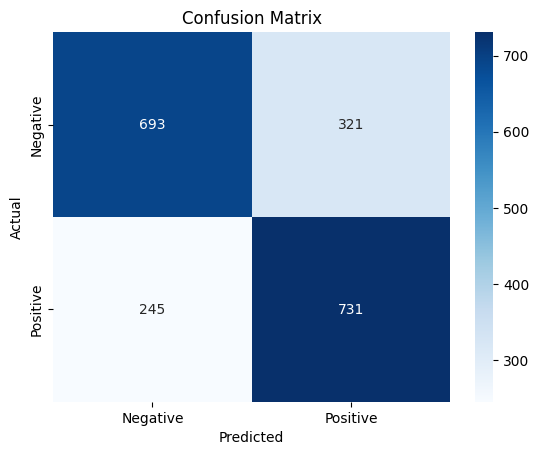

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
